In [1]:
#requrements
import sys
import pandas as pd
from datetime import datetime
import sklearn
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, matthews_corrcoef
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

Raw data taken from https://github.com/HUBioDataLab/DrugApp (thanks for data)

In [5]:
import requests
from io import StringIO

# URL of the raw CSV file on GitHub
url = "https://raw.githubusercontent.com/HUBioDataLab/DrugApp/main/datasets/training_datasets/All_drug_indication_raw_features.csv"

# Download the content of the file
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Read the content into a pandas DataFrame
    all_drugs = pd.read_csv(StringIO(response.text))
    print("Successfully loaded data from GitHub into the 'all_drugs' DataFrame.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Successfully loaded data from GitHub into the 'all_drugs' DataFrame.


/tmp/ipython-input-4221541068.py:13: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_drugs = pd.read_csv(StringIO(response.text))


In [6]:
display(all_drugs.head())

,SMILES,Label,DrugBank ID,Name,Patent_id,Status,NCT_Number,Conditions,Gender,Age_y,...,ECFP4.119,ECFP4.120,ECFP4.121,ECFP4.122,ECFP4.123,ECFP4.124,ECFP4.125,ECFP4.126,ECFP4.127,ECFP4.128
0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,1,DB00006,__BIVALIRUDIN,5196404.0,Completed,NCT00759083,HEPARIN-INDUCED THROMBOCYTOPENIA|HEPARIN-INDUC...,All,"18 Years and older (Adult, Older Adult)",...,0,1,1,1,1,1,0,1,1,0
1,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,1,DB00006,__BIVALIRUDIN,5196404.0,Recruiting,NCT03318393,EXTRACORPOREAL MEMBRANE OXYGENATION COMPLICATI...,All,"up to 18 Years (Child, Adult)",...,0,1,1,1,1,1,0,1,1,0
2,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,1,DB00006,__BIVALIRUDIN,5196404.0,Recruiting,NCT04445935,ANTICOAGULATION IN COVID-19 ARDS,All,"18 Years to 99 Years (Adult, Older Adult)",...,0,1,1,1,1,1,0,1,1,0
3,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,1,DB00006,__BIVALIRUDIN,5196404.0,Completed,NCT00262054,CORONARY DISEASE|ANGINA PECTORIS,All,"18 Years and older (Adult, Older Adult)",...,0,1,1,1,1,1,0,1,1,0
4,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,1,DB00006,__BIVALIRUDIN,5196404.0,Unknown status,NCT03588611,ACUTE CORONARY SYNDROME,All,"18 Years to 80 Years (Adult, Older Adult)",...,0,1,1,1,1,1,0,1,1,0


In [7]:
all_drugs['Label'].value_counts() # 1= approved,0 unapproved drug

,count
Label,
1,18427
0,2480


In [8]:
for col in all_drugs.columns:
    print(col)

SMILES
Label
DrugBank ID
Name
Patent_id
Status
NCT_Number
Conditions
Gender
Age_y
Funder_Type
Study Designs
Locations
CPC
Gender_code_0
Gender_code_1
Gender_code_2
Gender_code_3
Age_code_0
Age_code_1
Age_code_2
Age_code_3
Age_code_4
Age_code_5
Allocation_Type_0
Allocation_Type_1
Allocation_Type_2
Allocation_Type_3
Intervention_Model_0
Intervention_Model_1
Intervention_Model_2
Intervention_Model_3
Intervention_Model_4
Intervention_Model_5
Country_0
Country_1
Country_2
Country_3
Country_4
Country_5
Funder_Type_0
Funder_Type_1
Funder_Type_2
Funder_Type_3
Funder_Type_4
Funder_Type_5
claims_#
Duration
Patent_#
PCT_code_0
PCT_code_1
PCT_code_2
CPC_code_0
CPC_code_1
CPC_code_2
CPC_code_3
CPC_code_4
CPC_code_5
logP
MW
PSA
HBA
HBD
Rings
Polarizability
Refractivity
Bond_#
Bioavailability_0
Bioavailability_1
Bioavailability_2
ECFP4.1
ECFP4.2
ECFP4.3
ECFP4.4
ECFP4.5
ECFP4.6
ECFP4.7
ECFP4.8
ECFP4.9
ECFP4.10
ECFP4.11
ECFP4.12
ECFP4.13
ECFP4.14
ECFP4.15
ECFP4.16
ECFP4.17
ECFP4.18
ECFP4.19
ECFP4.20
EC

In [9]:
all_drugs['Conditions'].value_counts() # therapy/indication coverage

,count
Conditions,
HIV INFECTION,107
TYPE 2 DIABETES,98
HYPERTENSION,95
SCHIZOPHRENIA,93
CORONARY ARTERY DISEASE,89
...,...
ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION|NON ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION,1
HEALTHY NON-SMOKERS|CURRENT SMOKERS|COPD PATIENTS,1
UNCOMPLICATED FALCIPARUM MALARIA|ARTEMISININ-RESISTANT,1


In [10]:
all_drugs['Study Designs'].value_counts() # 467 type clinical trial study design coverage

,count
Study Designs,
Allocation: Randomized|Intervention Model: Parallel Assignment|Masking: None (Open Label)|Primary Purpose: Treatment,3520
Allocation: N/A|Intervention Model: Single Group Assignment|Masking: None (Open Label)|Primary Purpose: Treatment,2126
"Allocation: Randomized|Intervention Model: Parallel Assignment|Masking: Quadruple (Participant, Care Provider, Investigator, Outcomes Assessor)|Primary Purpose: Treatment",1859
"Allocation: Randomized|Intervention Model: Parallel Assignment|Masking: Double (Participant, Investigator)|Primary Purpose: Treatment",1003
"Allocation: Randomized|Intervention Model: Parallel Assignment|Masking: Triple (Participant, Care Provider, Investigator)|Primary Purpose: Treatment",645
...,...
Observational Model: Other|Time Perspective: Prospective,1
"Allocation: Randomized|Intervention Model: Single Group Assignment|Masking: Quadruple (Participant, Care Provider, Investigator, Outcomes Assessor)|Primary Purpose: Basic Science",1
Allocation: Randomized|Intervention Model: Crossover Assignment|Masking: Single (Participant)|Primary Purpose: Health Services Research,1


Deletion on all patents related features columns becouse patent does not play any significance role in Drug discovery or approval

In [11]:
#Droping patents related columns like from combined_df create final_df
drop_cols = ['Study Designs','Age_y','Patent_id','DrugBank ID','claims_#','Duration','Patent_#','PCT_code_0','PCT_code_1','PCT_code_2','CPC_code_0','CPC_code_1','CPC_code_2','CPC_code_3','CPC_code_4','CPC_code_5']
final_df=all_drugs.drop(drop_cols, axis=1)

In [12]:
drop_cal2=['Name', 'Status','NCT_Number','Funder_Type','Locations','CPC']
final_df=final_df.drop(drop_cal2, axis=1)

In [13]:
drop_cal3=['Gender','SMILES','Conditions']
final_df=final_df.drop(drop_cal3, axis=1)

In [14]:
final_df.shape

(20907, 173)

** Automatic Hyperparamer tuning Framework**

In [15]:
x=final_df.drop('Label', axis=1)
y=final_df['Label']

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [18]:
#create the model on above parameters
model=RandomForestClassifier(max_depth=26, n_estimators=20, min_samples_split=2, min_samples_leaf=1, criterion= 'log_loss' )

model.fit(x_train, y_train)
#make prediction and evaluation of model
y_pred=model.predict(x_test)
accuracy=accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.954849818251387


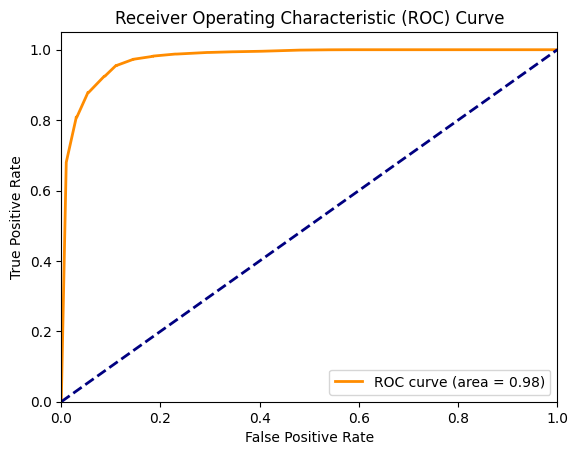

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Use the already trained RandomForestClassifier model

# Predict probabilities on the test set using the already trained 'model'
y_pred_proba = model.predict_proba(x_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

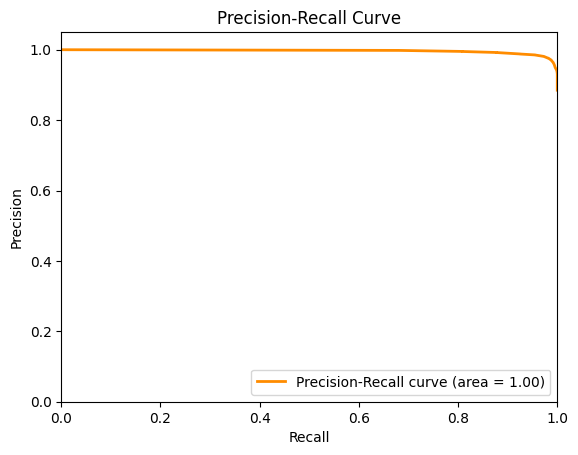

In [21]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Calculate the area under the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**Mearurement of model Randomclassifier evalution metrix roc curve and precision-recall curve**

**Trying with model XGBoost**

In [22]:
!pip install xgboost

In [26]:
from xgboost import XGBClassifier

In [27]:
model=XGBClassifier(
    n_estimators=122,
    max_depth=26,
    learning_rate=0.21,
    subsample=0.68,
    colsample_bytree=0.15,
    min_child_weight=2,
    reg_alpha=0.41,
    reg_lambda=0.07)

model.fit(x_train, y_train)
y_pred=model.predict(x_test)
accuracy=accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.970154964606849


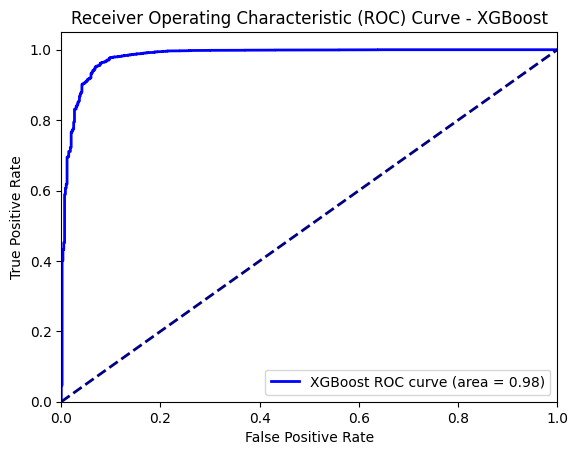

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


# Predict probabilities on the test set using the already trained 'model'
y_pred_proba_xgb = model.predict_proba(x_test)[:, 1]

# Calculate ROC curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label='XGBoost ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

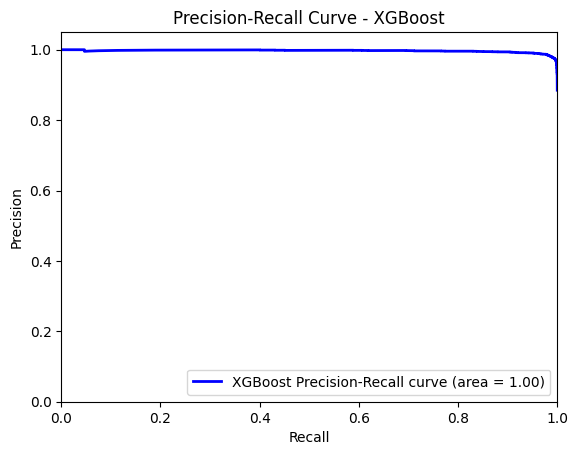

In [30]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities on the test set using the already trained 'model'
y_pred_proba_xgb = model.predict_proba(x_test)[:, 1]

# Calculate precision and recall
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)

# Calculate the area under the precision-recall curve
pr_auc_xgb = auc(recall_xgb, precision_xgb)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall_xgb, precision_xgb, color='blue', lw=2, label='XGBoost Precision-Recall curve (area = %0.2f)' % pr_auc_xgb)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()